# Lab 3 Part III: Transfer Learning



------------------------------------------------------
*Deep Learning. Master in Information Health Engineering *

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

In this notebook, you'll learn how to use pre-trained CNN networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. 

Once trained over Imagenet, CNNs models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy. With [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://www.pyimagesearch.com/wp-content/uploads/2016/08/knn_kaggle_dogs_vs_cats_sample.jpg", width=400, height=200)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

## Part I. Load the data set. Incorporate Data Augmentation

#### Dataset folder structure

The easiest way to load you own training/test image dataset is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a sequence of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. **More about this below**. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. 

You can check that the provided dataset has the required structure.

#### Data augmentation

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above). 

A common technique to enforce the invariancy of the CNN and obtain a more robust classifier is [Data Augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced), which seeks to train the neural network with additional synthetically modified data, generated by introducing randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/docs/stable/torchvision/transforms.html)

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.


To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered other than normalizing. So, for validation/test images, you'll typically just resize and crop.

With the following code, we load the dataset and implement a few transformations.

In [0]:
data_dir = '/content/drive/My Drive/Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train/', transform=train_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
tensor(0)
tensor(0)
tensor(0)


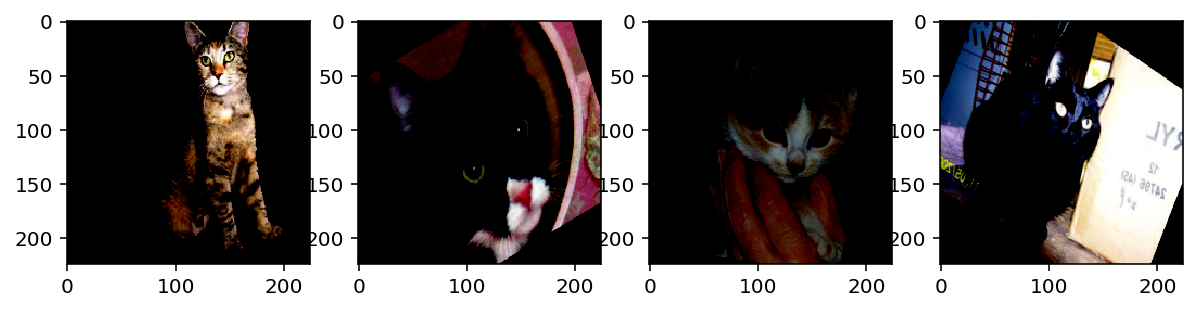

In [7]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    ax.imshow(images[ii,:,:,:].numpy().transpose((1,2,0)))
    print(labels[ii])

#### Normalizing according to DenseNet

In this notebook, we will use [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5) as feature extractor. It requires the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

With the following code, we load the dataset of cats & dogs, perform the data augmentation trasformations, and normalize the input images according to DenseNet.

In [0]:
data_dir = '/content/drive/My Drive/Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
valid_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train/', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation/', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test/', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [0]:
classes = ('cat', 'dog') #cat 0 and dog 1

## Part II. Loading DenseNet and modifing the last classification layer


[DensetNet](https://arxiv.org/abs/1608.06993) was proposed in the 2017 IEEE Conference on Computer Vision and Pattern Recognition, and it is one of the most popular CNNs for computer vision applications. 

The models is huge and contains millions of parameters. [This excellent post](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a) explains in detail the DenseNet structure. 

In [10]:
Image(url= "https://miro.medium.com/max/1138/1*GeK21UAbk4lEnNHhW_dgQA.png", width=400, height=200)

In [11]:
Image(url= "https://miro.medium.com/max/2846/1*SsphOqMwglCVGDWB-jdT5Q.png", width=800, height=200)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [12]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 26.1MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so **it won't work for our specific problem**. That means we need to replace the classifier, but the features will work perfectly on their own. In general, think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

Replacing the classifier is straightforward. We go step by step. 

> **Excercise:** Create a class for a NN binary classifier with only one dense layer with 500 hidden units

In [0]:
class MLP(nn.Module):
    def __init__(self,dim_input=1024, dim_h1=500, nlabels=2): 
             
        super().__init__()
                                                             
        self.output1 = nn.Linear(dim_input,dim_h1)
        self.output2 = nn.Linear(dim_h1,nlabels)

        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.logsoftmax(x) 

        return x

Now, we instantiate the class `MLP` we just created and replace the classifier part of DenseNet. Also, we freeze the rest of DenseNet parameters.

In [0]:

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = MLP()
    
# We overwrite model.classifier
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

> **Exercise**: Complete the following code for a class that trains the defined model.

Note that, to make things easier, this time **we pass the instatiated model as an input to the class!** (instead of using inheritance)

In [0]:
class Tran_Eval():
    
    
    def __init__(self,model,maxiter=500,lr=0.001):
        
        self.model = model
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)
        
        self.max_iter = maxiter
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        it_images = iter(trainloader)
        
        running_loss = 0.
        
        
        for e in range(int(self.max_iter)):

          
            images,labels = next(it_images)
            
            
            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)  
            self.optim.zero_grad() 
            out = self.model.forward(images)
            loss = self.criterion(out,labels)

            running_loss += loss.item()

            loss.backward()


        self.optim.step()
        self.loss_during_training.append(running_loss/len(trainloader)) 

        print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,self.loss_during_training[-1]))
        
        with torch.no_grad():
          validation_total = 0             

          for images,labels in validloader:
            
            images, labels = images.to(self.device), labels.to(self.device)  
            
            validation_out = self.forward(images)
            validation_loss = self.criterion(validation_out, labels)
            validation_total += validation_loss.item()
            
          self.valid_loss_during_training.append(validation_total/len(validloader))

    def eval_performance(self,dataloader,num_batches):

        accuracy = 0
        
        it_images = iter(dataloader)

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

          self.model.eval()

          for e in range(int(num_batches)):
            
              print('Batch %d of %d' %(e,num_batches))

              images, labels = next(it_images)
              images, labels = images.to(self.device), labels.to(self.device)

              probs = self.model.forward(images)
              self.top_p, self.top_class = probs.topk(1, dim=1)
              equals = (self.top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        return accuracy/num_batches

>**Exercise:** Train the model for a few epochs. Plot the loss/validation function and valuate the performance in both the training and test sets

In [0]:
model_with_train = Tran_Eval(model,maxiter=40)

In [34]:
model_with_train.trainloop(trainloader)

Batch 39 of 40 finished. Loss 0.059279


AttributeError: ignored

In [27]:
model_with_train.eval_performance(trainloader, 10)

Batch 0 of 10
Batch 1 of 10
Batch 2 of 10
Batch 3 of 10
Batch 4 of 10


KeyboardInterrupt: ignored

In [0]:
model_with_train.eval_performance(testloader, 10)

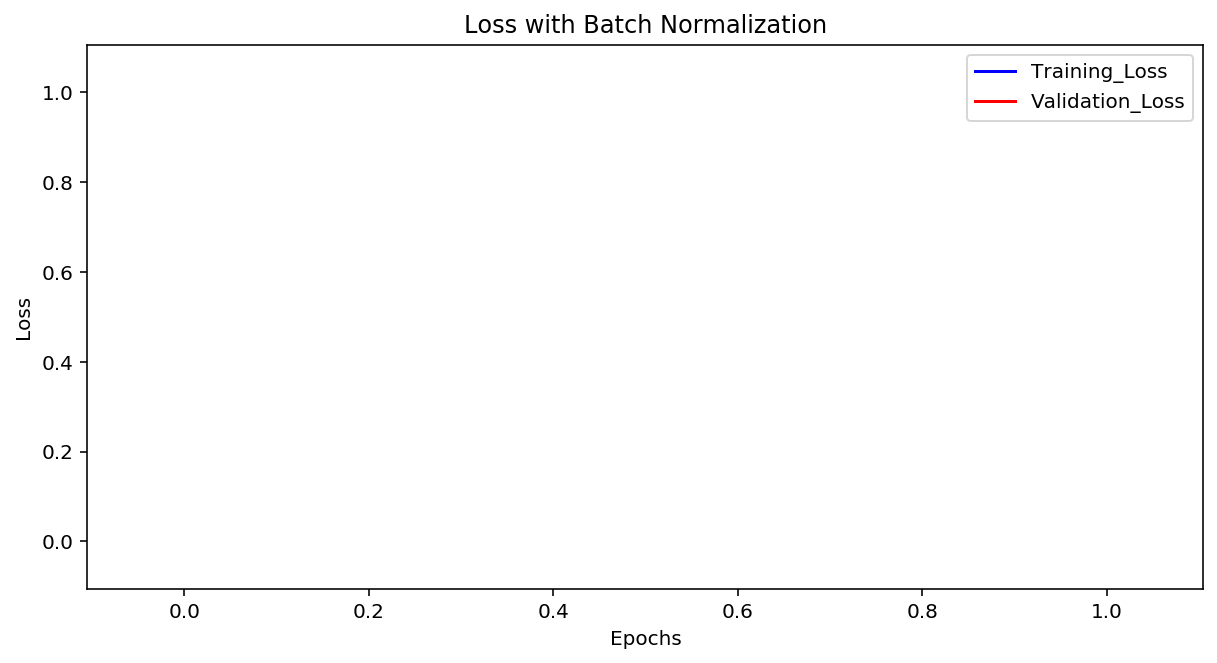

In [28]:
plt.figure(figsize=(10,5))
plt.plot(model_with_train.loss_during_training,'b', label='Training_Loss')
plt.plot(model_with_train.valid_loss_during_training,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with Batch Normalization')
plt.legend()
plt.show()